In [1]:
import os
import sys
import time

import numpy as np

from scipy import stats

from astropy import units as u
from astropy import constants as cnst
from astropy.coordinates import SkyCoord, Distance
from astropy import table
from astropy.table import Table
from astropy.io import fits
from astropy.visualization import hist as ahist

In [2]:
%matplotlib inline
from matplotlib import rcParams, style
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

rcParams['image.cmap'] = 'viridis'
rcParams['image.origin'] = 'lower'
rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
rcParams['figure.figsize'] = (14, 8)
rcParams['axes.titlesize'] =  rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] =  rcParams['ytick.labelsize'] = 14

In [195]:
from IPython import display

In [3]:
import data_loaders
import detectability

# Load ELVIS and GALFA

In [4]:
elvii_pairs = data_loaders.load_elvii_z0(isolated=False)

Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Hall&Oates.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Hamilton&Burr.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Kek&Kauket.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Lincoln&Douglas.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Orion&Taurus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Romulus&Remus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Scylla&Charybdis.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Serena&Venus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Siegfried&Roy.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Sonny&Cher.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Thelma&Louise.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Zeus&Hera.txt


In [5]:
res = data_loaders.load_galfa_sensitivity('onempc_mass_sens.fits.zip')
galfa_sens, galfa_sens_scs, galfa_sens_wcs, galfa_sens_hdu = res

/Users/erik/miniconda3/lib/python3.5/site-packages/astropy/coordinates/angles.py:656: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/lib/python3.5/site-packages/astropy/coordinates/angles.py:656: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/lib/python3.5/site-packages/astropy/coordinates/angles.py:547: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/erik/miniconda3/lib/python3.5/site-packages/astropy/coordinates/angles.py:547: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):


In [6]:
elvii_trees = data_loaders.load_elvii_trees('ID,Mvir,Vmax,Rvir,upID,scale')

Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Hall&Oates


/Users/erik/projects/m31-galfa/data_loaders.py:83: RuntimeWarning: divide by zero encountered in true_divide
  coldct['z'] = 1./coldct['scale'] - 1


Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Hamilton&Burr
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Kek&Kauket
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Lincoln&Douglas
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Orion&Taurus
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Romulus&Remus
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Scylla&Charybdis
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Serena&Venus
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Siegfried&Roy
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Sonny&Cher
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Thelma&Louise
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Zeus&Hera


# Compute detectability and findability for GALFA

In [7]:
#m31 = SkyCoord.from_name('M31')
m31 = SkyCoord(10.6847083*u.deg, 41.26875*u.deg, 700*u.kpc)

for tab in elvii_pairs.values():
    data_loaders.add_oriented_radecs(tab, 0, 1, target_coord=m31)
    data_loaders.add_oriented_radecs(tab, 1, 0, target_coord=m31)

/Users/erik/miniconda3/lib/python3.5/site-packages/astropy/units/quantity.py:782: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return super(Quantity, self).__eq__(other)


In [8]:
detectability.compute_elvis_mgas_bradford_15(elvii_pairs)

In [9]:
detectability.compute_elvis_detectability(galfa_sens, galfa_sens_wcs, 'dr1', elvii_pairs)

In [10]:
wakker_hvcs = Table.read('wakk.fits')
wakker_scs = SkyCoord(l=wakker_hvcs['L'], b=wakker_hvcs['B'], unit=u.deg, frame='galactic')

detectability.compute_elvis_findable(elvii_pairs, wakker_scs, wakker_hvcs['VLSR']*u.km/u.s)

# And figure out how to map halos to high-z 

In [11]:
for name, tree in elvii_trees.items():
    for z_re in (6,7,8,9):
        idxzre = np.argmin(np.abs(tree[0]['z']-z_re))    
        elvii_pairs[name]['Mviratz{}'.format(z_re)] = tree['Mvir'][:, idxzre]
        elvii_pairs[name]['Rviratz{}'.format(z_re)] = tree['Rvir'][:, idxzre]
        elvii_pairs[name]['Vmatz{}'.format(z_re)] = tree['Vmax'][:, idxzre]

# New set up machinery to count the number of z=0 detections given high-z cutoff details

In [12]:
def counts_with_cutoffs(Mviratzre=0*u.solMass, z_re=8, appmagcut=100*u.mag, inclsat=False):
    counts = []
    for pair in elvii_pairs.values():
        halos = pair[2:]
        for i in (0, 1):
            matches = halos['findable_dr1_host{}'.format(i)]
            
            if Mviratzre is not None:
                matches = matches & (halos['Mviratz{}'.format(z_re)] > Mviratzre)
            
            dm = Distance(halos['host{}_dist'.format(i)]).distmod
            appmag = -2.5*np.log10(halos['Mstar_preferred']/u.solMass)*u.mag + dm 
            matches = matches & (appmag < appmagcut)
            
            if not inclsat:
                matches = matches & ~halos['sat_of_either']
                
            counts.append(np.sum(matches))
    return np.array(counts)

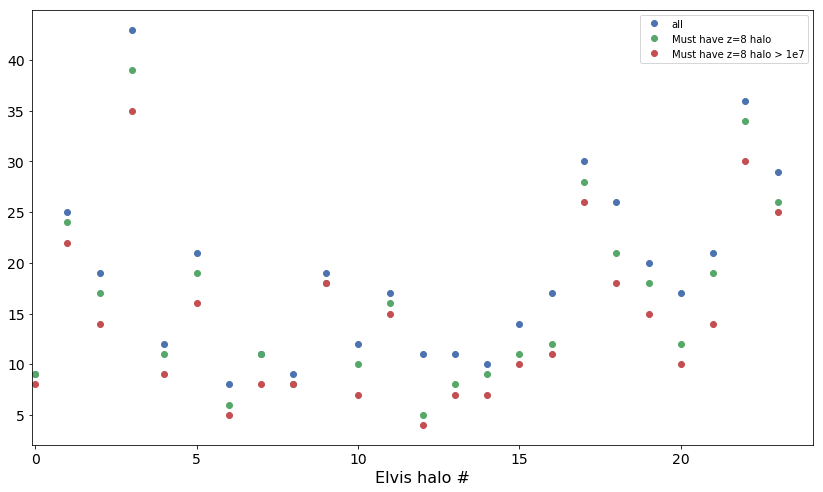

In [13]:
plt.plot(np.arange(len(elvii_pairs)*2), counts_with_cutoffs(None), 'o', label='all')
plt.plot(np.arange(len(elvii_pairs)*2), counts_with_cutoffs(), 'o', label='Must have z=8 halo')
plt.plot(np.arange(len(elvii_pairs)*2), counts_with_cutoffs(1e7*u.solMass), 'o', label='Must have z=8 halo > 1e7')

plt.xlim(-.1,len(elvii_pairs)*2 + .1)
plt.legend(loc=0)

plt.xlabel('Elvis halo #')

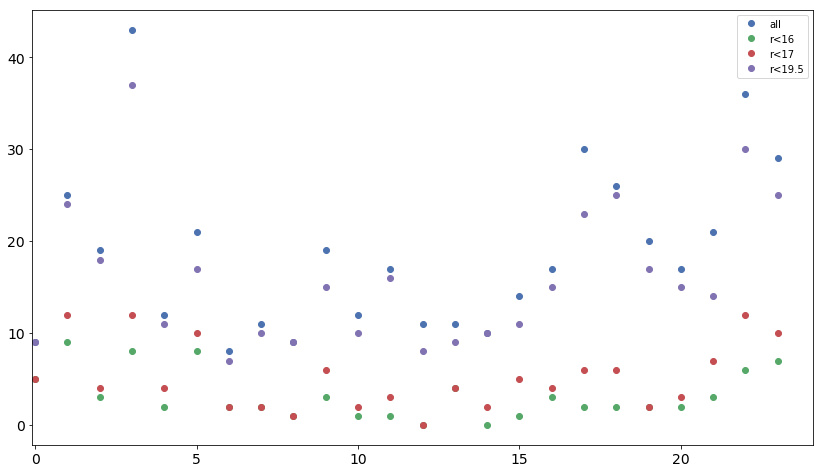

In [14]:
plt.plot(np.arange(len(elvii_pairs)*2), counts_with_cutoffs(None), 'o', label='all')
plt.plot(np.arange(len(elvii_pairs)*2), counts_with_cutoffs(None, appmagcut=(16-4.7)*u.mag), 'o', label='r<16')
plt.plot(np.arange(len(elvii_pairs)*2), counts_with_cutoffs(None, appmagcut=(17-4.7)*u.mag), 'o', label='r<17')
plt.plot(np.arange(len(elvii_pairs)*2), counts_with_cutoffs(None, appmagcut=(19.5-4.7)*u.mag), 'o', label='r<19.5')

plt.xlim(-.1,len(elvii_pairs)*2 + .1)
plt.legend(loc=0)

## Do probabilistic inference with Grid - requires some work to convert to Tvir

In [16]:
lmvg, rmg, zg = np.meshgrid(np.linspace(5.5,9.5, 25), 
                            np.linspace(8,22, 25), 
                            [6, 7, 8, 9])

In [17]:
vlnlike = np.vectorize(lnlike, excluded='dosmoothing,ncounts'.split(','))
st = time.time()
lnl = vlnlike(lmvg, zg, rmg, False)
et = time.time()
print((et-st)/lnl.size, 's per sample and', et-st, 's total')

/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log


0.072571808052063 s per sample and 181.42952013015747 s total


In [18]:
from astropy import modeling

xs6 = []
ys6 = []
xs9 = []
ys9 = []
for nm, pair in elvii_pairs.items():
    xs6.append(np.log10(pair['Mviratz6'].value))
    ys6.append(np.log10(pair['Rviratz6'].value))
    xs9.append(np.log10(pair['Mviratz9'].value))
    ys9.append(np.log10(pair['Rviratz9'].value))

mv6 = np.concatenate(xs6)
rv6 = np.concatenate(ys6)
mv9 = np.concatenate(xs9)
rv9 = np.concatenate(ys9)

mvs = np.concatenate((mv6, mv9))
rvs = np.concatenate((rv6, rv9))


msk = np.isfinite(mvs)&np.isfinite(rvs)
lmvirtolrvir = modeling.fitting.LinearLSQFitter()(modeling.models.Linear1D(), mvs[msk], rvs[msk])

/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10


/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in subtract
/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in subtract


<Linear1D(slope=0.33321461691151577, intercept=-1.4803268453825702)>

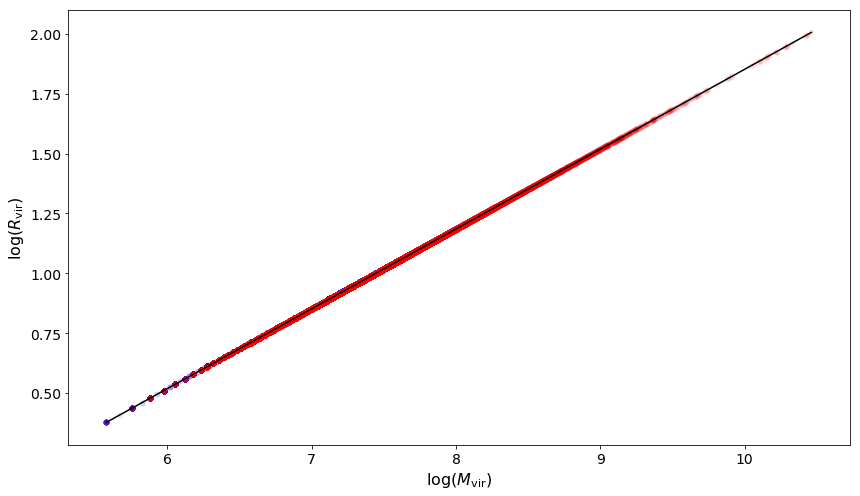

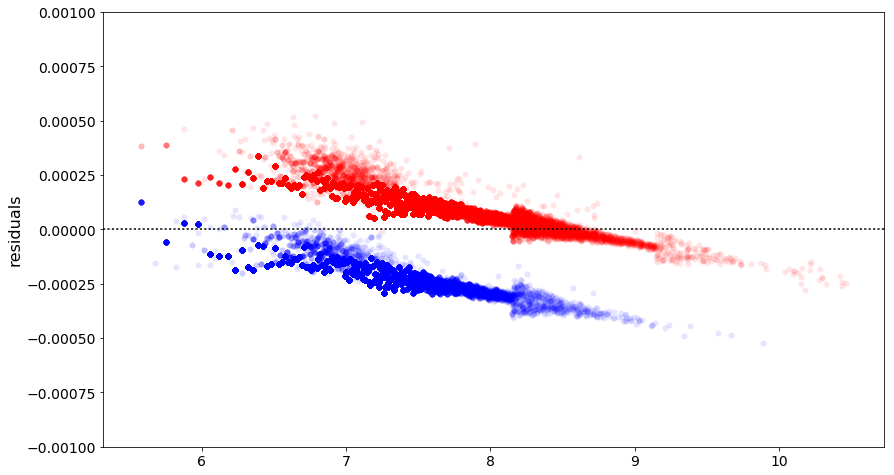

In [19]:
plt.scatter(mv9, rv9, lw=0, alpha=.1,c='b')
plt.scatter(mv6, rv6, lw=0, alpha=.1,c='r')


x = np.linspace(np.min(mvs[msk]), np.max(mvs[msk]), 100)
plt.plot(x, lmvirtolrvir(x),c='k',ls='-')
plt.xlabel(r'$\log(M_{\rm vir})$')
plt.ylabel(r'$\log(R_{\rm vir})$')

plt.figure()
plt.ylabel('residuals')
plt.scatter(mv9, lmvirtolrvir(mv9)-rv9, lw=0, alpha=.1,c='b')
plt.scatter(mv6, lmvirtolrvir(mv6)-rv6, lw=0, alpha=.1,c='r')
plt.axhline(0, ls=':', c='k')
plt.ylim(-.001,.001)
lmvirtolrvir

In [20]:
vtoltvir = lambda v: np.log10((0.6 * cnst.m_p*v**2 / 2 / cnst.k_B)/u.K)
def lmtoltvir(lmvir):
    lrvir = lmvirtolrvir(lmvir)
    vsq = cnst.G * 10**lmvir/10**lrvir * (u.solMass/u.kpc)
    return np.log10((0.6 * cnst.m_p*vsq / 2 / cnst.k_B)/u.K)

In [21]:
(0.6*cnst.m_p*(u.km/u.s)**2 / 2 / cnst.k_B).decompose()

<Quantity 36.34425591069938 K>

In [22]:
def v_to_tvir(v):
    res = (0.6 * cnst.m_p*v**2 / 2 / cnst.k_B)
    return res.to(u.K)
def tvir_to_v(tvir):
    vsq = (tvir/0.6/cnst.m_p * 2 * cnst.k_B)
    return (vsq**0.5).to(u.km/u.s)
#barkana&loeb 99 say Vc~13 km/s is the evaporation vcutoff
tv_cut = v_to_tvir(13*u.km/u.s)
tv_cut, np.log10(tv_cut/u.K)

(<Quantity 6142.1792489081945 K>, <Quantity 3.788322486427433>)

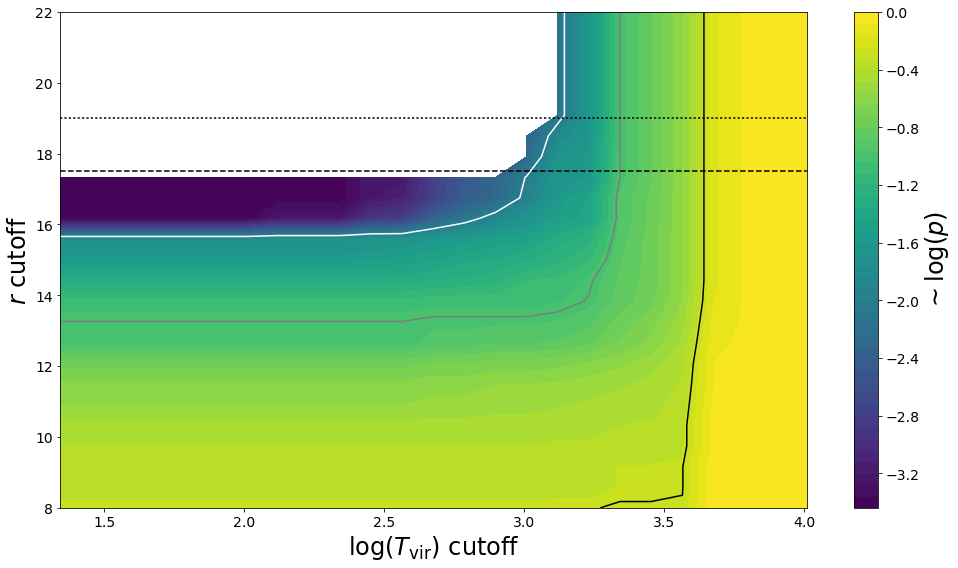

In [23]:
pish = np.mean(lnl, axis=2)
pish -= np.max(pish)

plt.contourf(lmtoltvir(lmvg[:,:,0]), rmg[:,:,0], pish, 50)
plt.colorbar().set_label(r'$\sim \log(p)$', fontsize=24)
plt.contour(lmtoltvir(lmvg[:,:,0]), rmg[:,:,0], pish, [-2, -1, np.log10(0.5)], cmap='Greys')
plt.axhline(17.5+1.5, c='k', ls=':')
plt.axhline(17.5, c='k', ls='--')
plt.xlabel(r'$\log(T_{\rm vir})$ cutoff', fontsize=24)
plt.ylabel(r'$r$ cutoff', fontsize=24)
plt.tight_layout()
fig = plt.gcf()

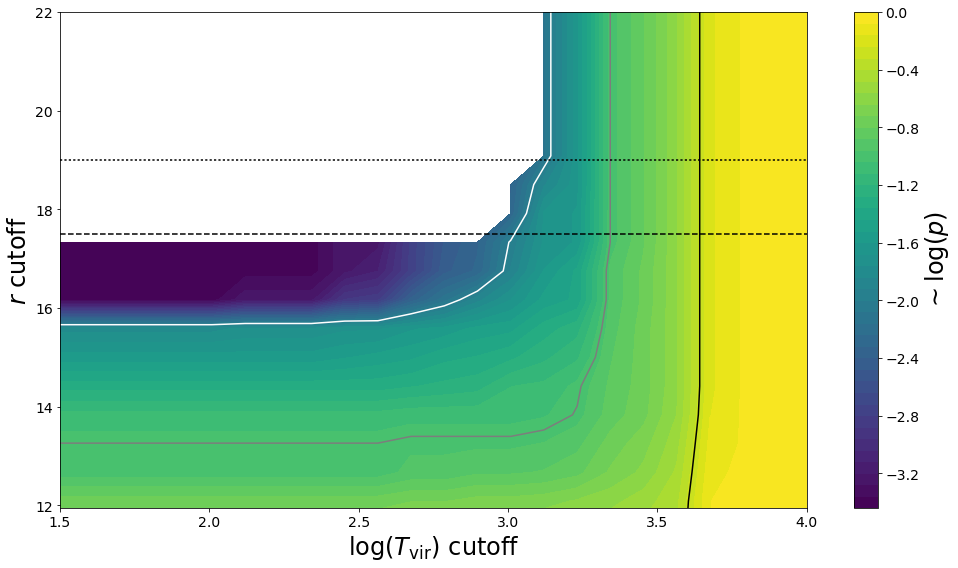

In [24]:
fig.axes[0].set_xlim(1.5,4)
fig.axes[0].set_ylim(11.95,22)
#fig.savefig('/Users/erik/Desktop/reionizationp_noupid.pdf')
fig

# Write out simplified tables for sharing

In [23]:
tabs = []

for nm, pair in elvii_pairs.items():
    for i in (0, 1):
        hostname = nm.split('&')[i]
        tab = Table()
        tab['mock_RA'] = pair['host{}_lon'.format(i)]
        tab['mock_Dec'] = pair['host{}_lat'.format(i)]
        tab['mock_dist'] = pair['host{}_dist'.format(i)]
        tab['M_HI'] = pair['MHI']
        tab['Mpeak'] = pair['Mpeak']
        tab['Mvir_now'] = pair['Mvir']
        tab['flux_enough_for_GALFA'] = pair['detectable_dr1_host{}'.format(i)]
        tab['findable_in_GALFA'] = pair['findable_dr1_host{}'.format(i)]
        tab['host_name'] = np.empty(len(tab), dtype='S'+str(len(hostname)))
        tab['host_name'][:] = hostname
        tabs.append(tab)
        
combined_tab = table.vstack(tabs)
#combined_tab.write('combined_tab.fits', format='fits')

Andrew's suggestions to try:

* add .3 dex scatter to SMHMR
* use past upID!=-1 instead of "is sat now

Josh's  suggestion:
* check halo counts vs vlsr of M31ish

# Try plotting up halos near the 50% cutoff

In [25]:
lmvir0 = []
lmpeak = []
lmstars = []
lmgass = []
for nm, pair in elvii_pairs.items():
    lmvir0.append(np.log10(pair['Mvir']/u.solMass))
    lmpeak.append(np.log10(pair['Mpeak']/u.solMass))
    lmstars.append(np.log10(pair['Mstar_preferred']/u.solMass))
    lmgass.append(np.log10(pair['MHI']/u.solMass))

lmvir0 = np.concatenate(lmvir0)
lmpeak = np.concatenate(lmpeak)
lmstars = np.concatenate(lmstars)
lmgass = np.concatenate(lmgass)

In [26]:
leot_mstar = 1.4e5*u.solMass
leot_mhi = 2.8e5*u.solMass

/Users/erik/miniconda3/lib/python3.5/site-packages/astropy/units/quantity.py:841: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__truediv__(other)
/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater
/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less


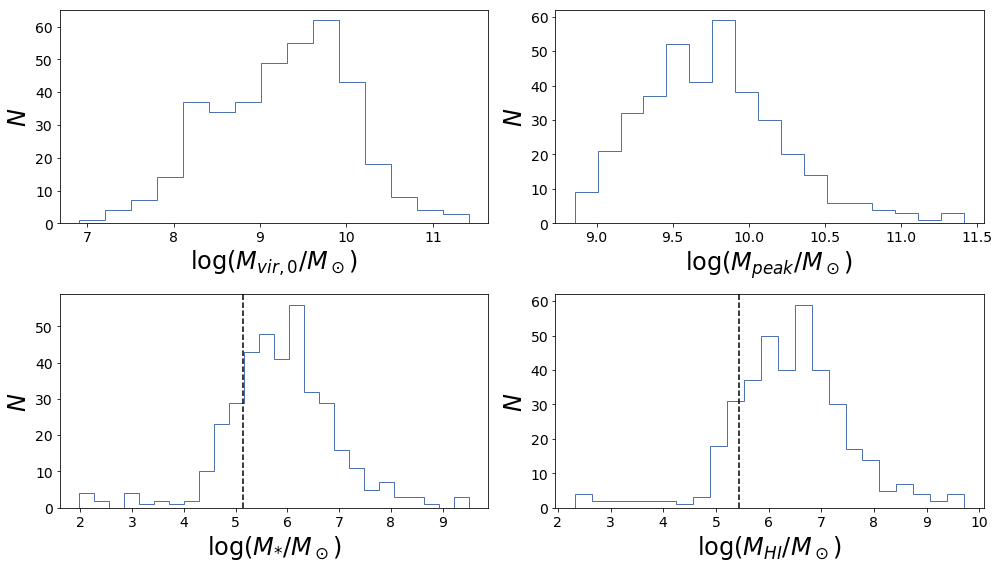

In [27]:
ltv6 = lmtoltvir(mv6)
ltv9 = lmtoltvir(mv9)
#meanlt = np.log10(10**ltv6 + 10**ltv9) - np.log10(2)
meanlt = ltv6


near50 = (3.5 < meanlt) & (meanlt< 3.75)

plt.subplot(2, 2, 1)
ahist(lmvir0[near50], bins='knuth', histtype='step')
plt.xlabel(r'$\log(M_{vir,0}/M_\odot)$', fontsize=24)
plt.ylabel(r'$N$', fontsize=24)

plt.subplot(2, 2, 2)
ahist(lmpeak[near50], bins='knuth', histtype='step')
plt.xlabel(r'$\log(M_{peak}/M_\odot)$', fontsize=24)
plt.ylabel(r'$N$', fontsize=24)

plt.subplot(2, 2, 3)
ahist(lmstars[near50], bins='knuth', histtype='step')
plt.xlabel(r'$\log(M_{*}/M_\odot)$', fontsize=24)
plt.ylabel(r'$N$', fontsize=24)
plt.axvline(np.log10(leot_mstar/u.solMass), ls='--', c='k')

plt.subplot(2, 2, 4)
ahist(lmgass[near50], bins='knuth', histtype='step')
plt.xlabel(r'$\log(M_{HI}/M_\odot)$', fontsize=24)
plt.ylabel(r'$N$', fontsize=24)
plt.axvline(np.log10(leot_mhi/u.solMass), ls='--', c='k')

plt.tight_layout()

#plt.savefig('/Users/erik/Documents/presentations/Hotsci2016/50percprops.pdf')

# Simplified cutoff plot 

In [28]:
pish = np.mean(lnl, axis=2)
#pish = lnl[:,:, 0]
pish -= np.max(pish)

magtoslice = 19
diff = np.abs(rmg[:,:,0] - magtoslice)
closest = np.min(diff) == diff

assert len(np.unique(rmg[closest])) == 1
rmclosest = rmg[closest][0]

lmclose = lmvg[:,:,0][closest]
ltvclose = lmtoltvir(lmclose)
pclose = pish[closest]

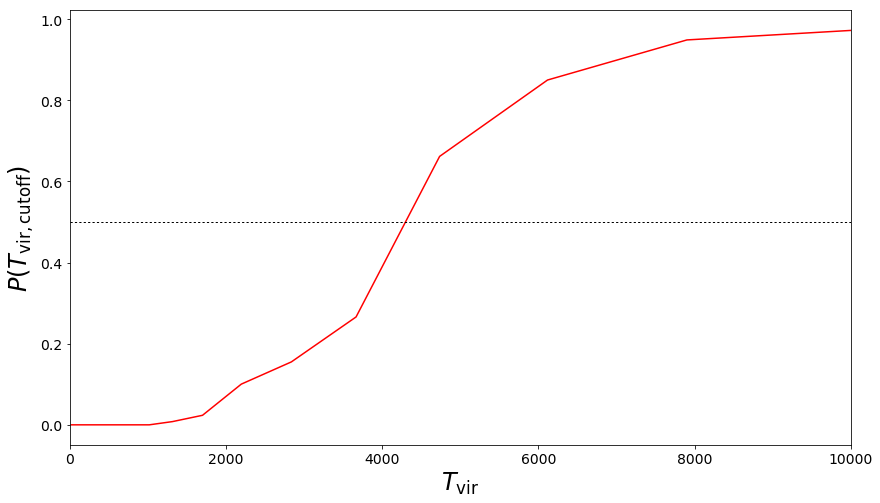

In [29]:
plt.plot(10**ltvclose, 10**pclose, c='r')
plt.xlim(0,10000)
plt.axhline(.5, ls=':', lw=1, c='k')


plt.xlabel(r'$T_{\rm vir}$', fontsize=24)
plt.ylabel(r'$P(T_{\rm vir, cutoff})$', fontsize=24)

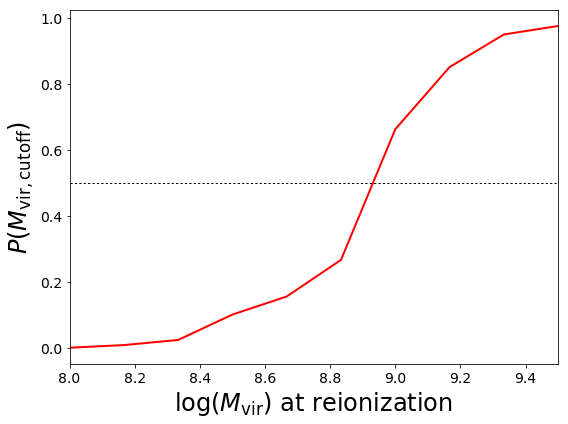

In [30]:
plt.figure(figsize=(8,6))

plt.plot(lmclose, 10**pclose, lw=2, c='r')
plt.axhline(.5, ls=':', lw=1, c='k')

plt.xlim(8, 9.5)

plt.xlabel(r'$\log(M_{\rm vir})$ at reionization', fontsize=24)
plt.ylabel(r'$P(M_{\rm vir, cutoff})$', fontsize=24)

plt.tight_layout()

plt.savefig('P_Mvir_cutoff.pdf')

## Now lets see what Leo T-analogs' high-z typical mass was

324

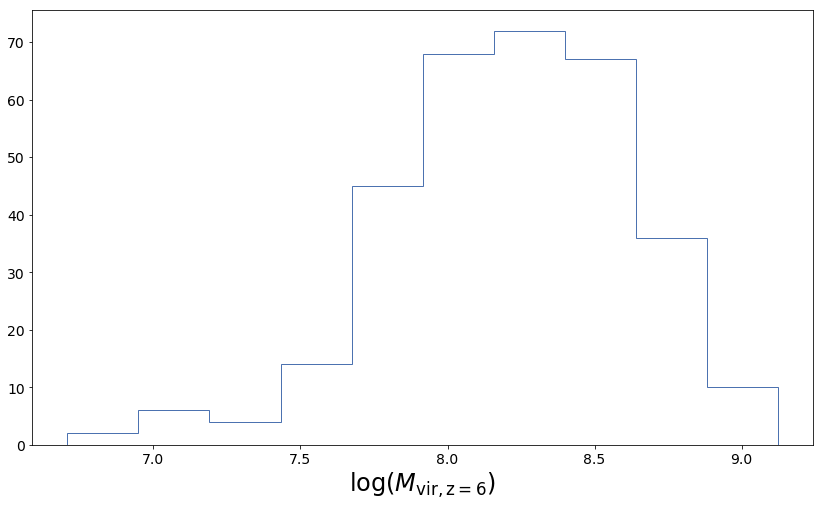

In [32]:
leot_lmstar = np.log10(leot_mstar/u.solMass)

dlmstar = .1
nearleot = ((leot_lmstar-dlmstar) < lmstars)&(lmstars < (leot_lmstar+dlmstar))

ltnear = meanlt[nearleot]
lmnear6 = mv6[nearleot]

plt.hist(lmnear6[np.isfinite(lmnear6)], histtype='step')
plt.xlabel(r'$\log(M_{\rm vir,z=6})$', fontsize=24)

np.sum(nearleot)

## Now combine that with the cutoff limit to get a guess for true cutoff 

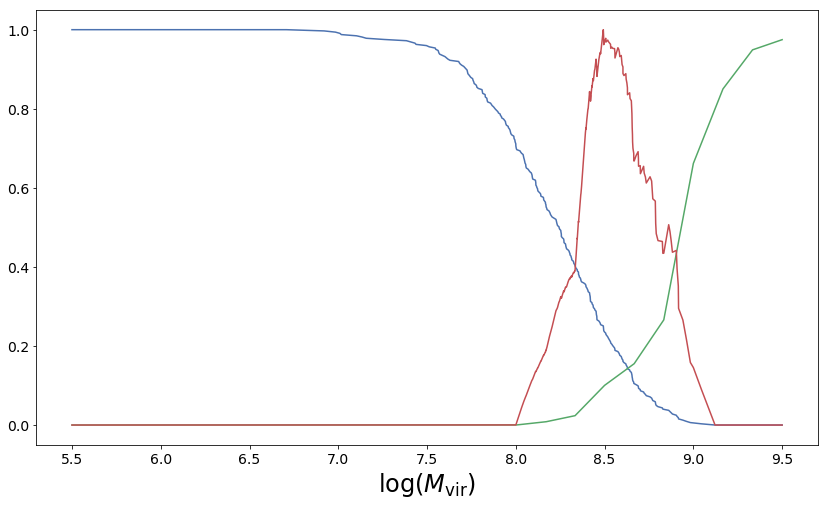

In [35]:
leot_cdfx = np.sort(lmnear6[np.isfinite(lmnear6)])
leot_cdfy = np.linspace(1, 0, len(lmnear6))

#plt.plot(leot_cdfx, leot_cdfy)
#plt.plot(lmclose, 10**pclose)

combined_x = np.sort(np.concatenate((leot_cdfx, lmclose)))

leot_cdf_combined = np.interp(combined_x, leot_cdfx, leot_cdfy)
cutoff_cdf_combined = np.interp(combined_x, lmclose, 10**pclose)
both_cdfs_combined = leot_cdf_combined*cutoff_cdf_combined
both_cdfs_combined /= np.max(both_cdfs_combined)

plt.plot(combined_x, leot_cdf_combined)
plt.plot(combined_x, cutoff_cdf_combined)
plt.plot(combined_x, both_cdfs_combined)

plt.xlabel(r'$\log(M_{\rm vir})$', fontsize=24)

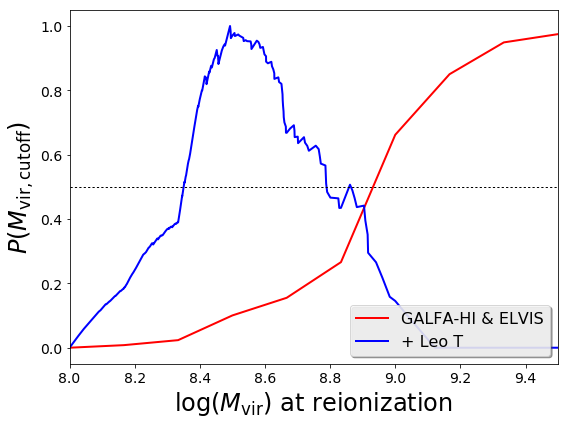

In [37]:
plt.figure(figsize=(8,6))

plt.plot(lmclose, 10**pclose, lw=2, c='r', label='GALFA-HI & ELVIS')
plt.plot(combined_x, both_cdfs_combined, lw=2,c='b', label='+ Leo T')
plt.axhline(.5, ls=':', lw=1, c='k')

plt.xlim(8, 9.5)

plt.xlabel(r'$\log(M_{\rm vir})$ at reionization', fontsize=24)
plt.ylabel(r'$P(M_{\rm vir, cutoff})$', fontsize=24)
plt.legend(loc='lower right', fontsize=16, shadow=True) 
plt.tight_layout()

#plt.savefig('P_Mvir_cutoff_wLeoT.pdf')

# Re-worked figure plots 

* Have "green" figure be only down to 1/100, fade to white-ish, have *both* horizontal lines
* Have above plot but in 3-line form (Leo T, GALFA, combined), with combined *filled* histogram.  Use z~6, and justify loosely, but don't worry too much about specific choice.
* Try doing above plot for both now and never case, use never if it's not way different

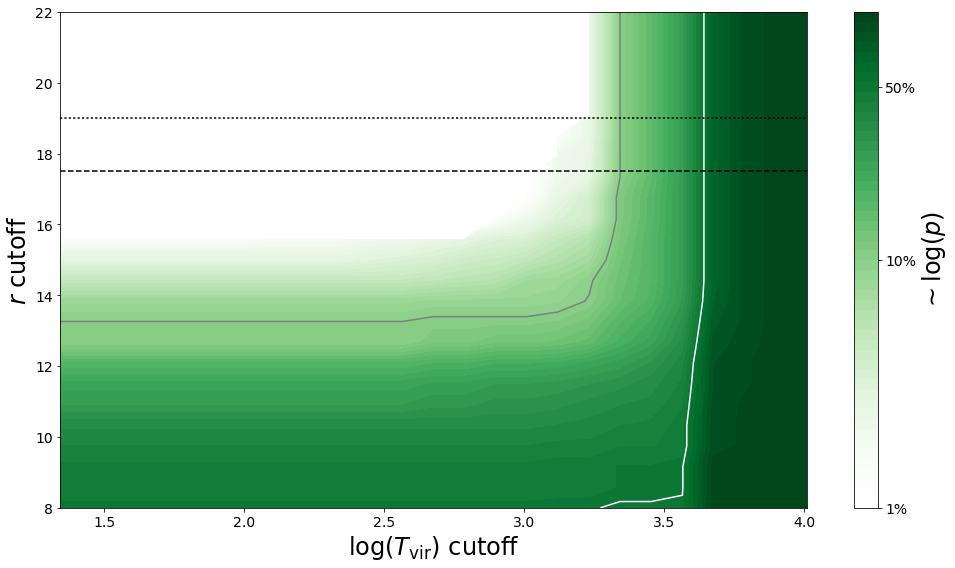

In [176]:
pish = np.mean(lnl, axis=2)
pish -= np.max(pish)

pish_floored = pish.copy()
pish_floored[pish<-2] = -np.inf

cmapdata = list(plt.cm.datad['Greens'])
cmapdata.insert(0, (1,1,1))
newcm = plt.cm.colors.LinearSegmentedColormap.from_list('test', cmapdata, N=256)

cnt = plt.contourf(lmtoltvir(lmvg[:,:,0]), rmg[:,:,0], pish_floored, 50,  
             cmap=newcm)
cb = plt.colorbar()
cb.set_label(r'$\sim \log(p)$', fontsize=24)
cb.set_ticks([-2, -1, np.log10(0.5)])
cb.set_ticklabels(['1%', '10%', '50%'])

plt.contour(lmtoltvir(lmvg[:,:,0]), rmg[:,:,0], pish_floored, [-1, np.log10(0.5)], 
            cmap='Greys_r', vmin=-1.5)

plt.axhline(17.5+1.5, c='k', ls=':')
plt.axhline(17.5, c='k', ls='--')
plt.xlabel(r'$\log(T_{\rm vir})$ cutoff', fontsize=24)
plt.ylabel(r'$r$ cutoff', fontsize=24)
plt.tight_layout()
plt.savefig('reionizationp_green.pdf')

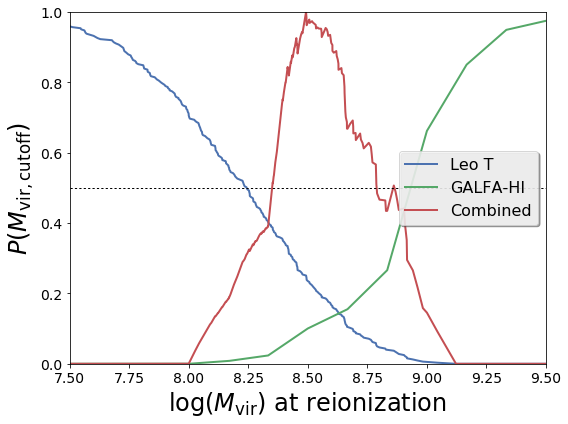

In [194]:
plt.figure(figsize=(8,6))

combined_x = np.sort(np.concatenate((leot_cdfx, lmclose)))

leot_cdf_combined = np.interp(combined_x, leot_cdfx, leot_cdfy)
cutoff_cdf_combined = np.interp(combined_x, lmclose, 10**pclose)
both_cdfs_combined = leot_cdf_combined*cutoff_cdf_combined
both_cdfs_combined /= np.max(both_cdfs_combined)

plt.plot(combined_x, leot_cdf_combined, lw=2, label='Leo T')
plt.plot(combined_x, cutoff_cdf_combined, lw=2, label='GALFA-HI')
plt.plot(combined_x, both_cdfs_combined, lw=2, label='Combined')
plt.axhline(.5, ls=':', lw=1, c='k')

plt.xlim(7.5, 9.5)
plt.ylim(0, 1.0)

plt.xlabel(r'$\log(M_{\rm vir})$ at reionization', fontsize=24)
plt.ylabel(r'$P(M_{\rm vir, cutoff})$', fontsize=24)
plt.legend(loc='center right', fontsize=16, shadow=True) 
plt.tight_layout()
#plt.savefig('leot_galfa_combo_notnow.pad')

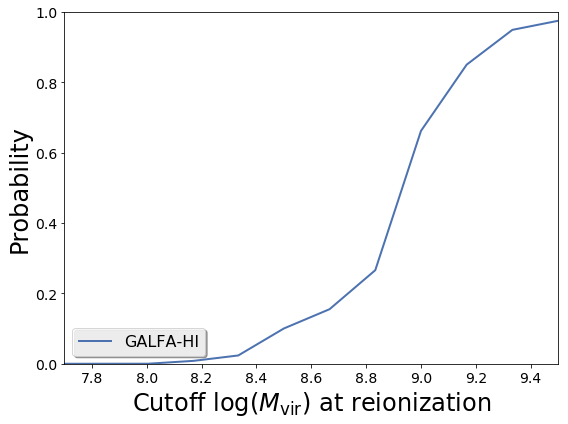

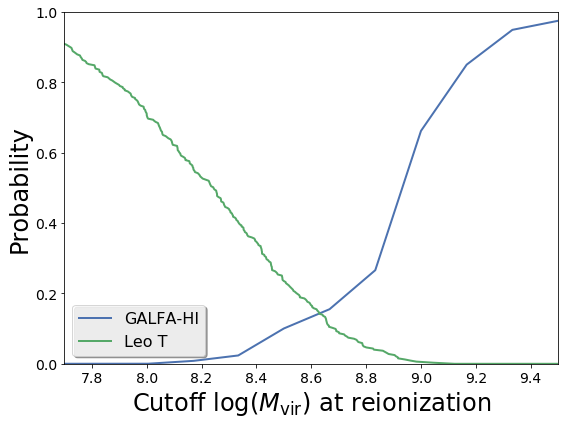

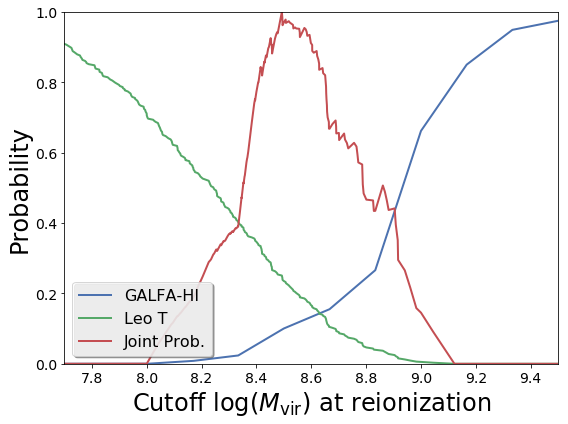

In [209]:
# with builds for talks

plt.figure(figsize=(8,6))

def set_axs():
    plt.xlim(7.7, 9.5)
    plt.ylim(0, 1.0)
    plt.xlabel(r'Cutoff $\log(M_{\rm vir})$ at reionization', fontsize=24)
    plt.ylabel(r'Probability', fontsize=24)
    plt.legend(loc='lower left', fontsize=16, shadow=True) 
    plt.tight_layout()

combined_x = np.sort(np.concatenate((leot_cdfx, lmclose)))

leot_cdf_combined = np.interp(combined_x, leot_cdfx, leot_cdfy)
cutoff_cdf_combined = np.interp(combined_x, lmclose, 10**pclose)
both_cdfs_combined = leot_cdf_combined*cutoff_cdf_combined
both_cdfs_combined /= np.max(both_cdfs_combined)

plt.plot(combined_x, cutoff_cdf_combined, lw=2, label='GALFA-HI')
set_axs()
plt.savefig('LeoT_combined_build1.pdf')
display.display(plt.gcf())
plt.plot(combined_x, leot_cdf_combined, lw=2, label='Leo T')
set_axs()
plt.savefig('LeoT_combined_build2.pdf')
display.display(plt.gcf())
plt.plot(combined_x, both_cdfs_combined, lw=2, label='Joint Prob.')
set_axs()
plt.savefig('LeoT_combined_build3.pdf')
display.display(plt.gcf())

#plt.legend(loc='center right', fontsize=16, shadow=True) 
plt.close()